# **Introducción al Cálculo: Funciones, derivadas y algo más**

En este tutorial es una introducción al **Cálculo**, principalmente el concepto de derivadas, dando algunas definiciones claves del área y tratando de ir anticipando su relevancia en **Machine Learning** y **Deep Learning**. Asumiremos que no tienen un conocimiento del área pero si que estan minimamente familiarizados con los conceptos básicos de **función** y la mátematica necesaria de un curso de pregrado.

¿Que **SÍ** busca esta clase?:

* Construir una intuición de acerca de las funciones, las derivadas y las integrales en 1 y más variables
* Brindar herramientas para su cálculo en Python
* Familiarizarse y entender las diferencias entre las herramientas para calcular derivadas de manera simbólica y de manera numérica
* Familiarizarse con la idea de integración numérica usando la suma de Riemann

¿Qué **NO** busca esta clase?

* Cubrir completamente derivadas ni todos los conceptos que se discuten en esta notebook. Para esto se necesitaría al menos uno o dos curso de Cálculo o Análisis Matemático

Esta clase es una adaptación del precurso de la escuela de [Computational Neuroscience](https://compneuro.neuromatch.io/) de [Neuromatch Academy](https://academy.neuromatch.io/) y del material del libro [Hands-on Deep Learning with Scikit-Learn, Tensorflow and Keras](https://github.com/ageron/handson-ml2).

Dejaremos algunas referencias generales al final para que puedan profundizar en cada uno de los temas según los conocimientos de cada uno/una de ustedes. También utilizaremos (*) en el nombre de las sección que son optitivas debido a que su uso en DL es bastante poco relevante.

---
# Configuracion 

## Instalar dependencias

In [10]:
#@title Imports

import numpy as np
import scipy.optimize as opt  # import root-finding algorithm
import sympy as sp  # Python toolbox for symbolic maths
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Toolbox for rendring 3D figures
from mpl_toolkits import mplot3d  # Toolbox for rendring 3D figures

## Configurar las figuras

In [11]:
# @title Settings
import ipywidgets as widgets  # interactive display
from ipywidgets import interact
#%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
sns.set_theme(style='darkgrid')
my_layout = widgets.Layout()

fig_w, fig_h = 9, 6
my_fontsize = 14
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': [fig_w, fig_h],
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-2,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-1,
          'ytick.labelsize': my_fontsize-1}

plt.rcParams.update(my_params)

## Otras funciones

In [12]:
# Funciones de figuras
def move_sympyplot_to_axes(p, ax):
    backend = p.backend(p)
    backend.ax = ax
    backend.process_series()
    backend.ax.spines['right'].set_color('none')
    backend.ax.spines['bottom'].set_position('zero')
    backend.ax.spines['top'].set_color('none')
    plt.close(backend.fig)


def plot_functions(function, show_derivative, show_integral):

  # For sympy we first define our symbolic variable
  x, y, z, t, f = sp.symbols('x y z t f')

  # We define our function
  if function == 'Lineal':
    f = -2*t
    name = r'$-2t$'
  elif function == 'Cuadrática':
    f =  t**2
    name = r'$t^2$'
  elif function == 'Exponencial':
    f =  sp.exp(t)
    name = r'$e^t$'
  elif function == 'Seno':
    f =  sp.sin(t)
    name = r'$sin(t)$'
  elif function == 'Sigmoidea':
    f = 1/(1 + sp.exp(-(t-5)))
    name = r'$\frac{1}{1+e^{-(t-5)}}$'

  if show_derivative and not show_integral:
    # Calculate the derivative of sin(t) as a function of t
    diff_f = sp.diff(f)
    print('Derivada de', f, 'es ', diff_f)

    p1 = sp.plot(f, diff_f, show=False)
    p1[0].line_color='r'
    p1[1].line_color='b'
    p1[0].label='Función'
    p1[1].label='Derivada'
    p1.legend=True
    p1.title = 'Función = ' + name + '\n'
    p1.show()
  elif show_integral and not show_derivative:

    int_f = sp.integrate(f)
    int_f = int_f - int_f.subs(t, -10)
    print('Integral de ', f, 'es ', int_f)


    p1 = sp.plot(f, int_f, show=False)
    p1[0].line_color='r'
    p1[1].line_color='g'
    p1[0].label='Función'
    p1[1].label='Integral'
    p1.legend=True
    p1.title = 'Función = ' + name + '\n'
    p1.show()


  elif show_integral and show_derivative:

    diff_f = sp.diff(f)
    print('Derivada de', f, 'es ', diff_f)

    int_f = sp.integrate(f)
    int_f = int_f - int_f.subs(t, -10)
    print('Integral de', f, 'es ', int_f)

    p1 = sp.plot(f, diff_f, int_f, show=False)
    p1[0].line_color='r'
    p1[1].line_color='b'
    p1[2].line_color='g'
    p1[0].label='Function'
    p1[1].label='Derivative'
    p1[2].label='Integral'
    p1.legend=True
    p1.title = 'Function = ' + name + '\n'
    p1.show()

  else:

    p1 = sp.plot(f, show=False)
    p1[0].line_color='r'
    p1[0].label='Function'
    p1.legend=True
    p1.title = 'Function = ' + name + '\n'
    p1.show()


def plot_alpha_func(t, f, df_dt):

  plt.figure()
  plt.subplot(2,1,1)
  plt.plot(t, f, 'r', label='PSP')
  plt.xlabel('')
  plt.ylabel('Voltaje')
  plt.legend()
  

  plt.subplot(2,1,2)
  plt.plot(t, df_dt, 'b', label='Derivada del PSP')
  #plt.title('Derivative of alpha function')
  plt.xlabel('Tiempo')
  plt.ylabel('df/dt')
  plt.legend()


def plot_charge_transfer(t, PSP, numerical_integral):

  fig, axes = plt.subplots(1, 2)

  axes[0].plot(t, PSP)
  axes[0].set(xlabel = 't', ylabel = 'PSP')

  axes[1].plot(t, numerical_integral)
  axes[1].set(xlabel = 't', ylabel = 'Charge Transferred')

# adapatada de hands-on
def show(axis="equal", ax=None, title=None, xlabel="$x$", ylabel="$y$"):
    ax = ax or plt.gca()
    ax.axis(axis)
    #ax.grid()
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14, rotation=0)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

---
# 1 - ¿Que es el cáculo? Funciones, derivadas e integrales, una interpretación geométrica

El cálculo es una parte de las matemáticas que se ocupa del **cambio continuo** de un objeto en particular que son las **funciones**, es decir que estudia que sucede con las distintas variaciones que tienen las funciones. Hay dos ramas del cálculo: cálculo diferencial y cálculo integral, y comenzaremos con una introducción al primero.

Recordemos que una **función** $f$ en matemática es un tipo de relación entre dos conjuntos, el **dominio** y el **codominio**, en nuestro caso esos conjuntos serán los [números reales](https://es.wikipedia.org/wiki/N%C3%BAmero_real) denotado con $\mathbb{R}$, pero pueden ser otros conjuntos. Para denotar de donde y hacia donde llega la función solemos escribir:

\begin{align}
f: \mathbb{R} &\rightarrow \mathbb{R}\\
\mathcal{x} &\mapsto f(x)
\end{align}

Esto quiere decir que $f$ toma como entrada un número real $x$ y devuelve otro número real reales como salida. Podemos hacer una analogía con una máquina que recibe una entrada y devuelve algo transformado. Sin embargo, no cualquier relación es un función sino que como requisito, **para cada valor de entrada, la función le asigna un único valor de salida**.

In [13]:
# ejemplos de función en python
def mi_fun(x):
  y = x**2 - 2
  return y
print(mi_fun(3))

# no necesitamos necesariamente usar def para armar una función sino que podemos
# usar funciones lambda o anónimas
f = lambda x: x**2 -2
print(f(3))

7
7


La derivada de una funcion $f(x)$ es una nueva funcion que de alguna manera cauntifica como varia la funcion con respecto a su variable $t$. Existen muchas maneras de notar la derivada de $f$, en funciones de una variable de suele usar $f'(t)$ pero tambien (*disclaimer*: para facilitar esta explicacion asurimeros que esta derivada existe en todo el dominio de $f$ lo cual podria no suceder):

\begin{equation}
\partial_x f(x) = \frac{d(f(x))}{dx} = \frac{df}{dx} (x): \mathbb{R} \rightarrow \mathbb{R}
\end{equation}

Esta derivada captura que tan sensible es una funcion a cambios leves en la entrada para diferentes rangos de entradas. Geometricamente, la derivada de una funcion de una variable en cierta entrada ea la **pendiente** de una recta que es tangente a la funcion en la salida de esa funcion. Retomaremos esta idea en breve.

Por ejemplo, supongamos que condicimos un vehiculo y la distancia recorrida cambia continuamente con el tiempo representado por una funcion $f$. La derivada de la distancia recorrida con respecto al tiempo es la velocidad del vehiculo en cada punto del tiempo. La velocidad te dice la tasa de cambio de la distancia recorrida  en diferentes puntos en el tiempo.  Si tiene una velocidad lenta (una  pequeña derivada), la distancia recorrida no cambia mucho por pequeños cambios en el tiempo. Una velocidad alta (derivada grande) significa que la distancia recorrida cambia mucho para pequeños cambios en el tiempo.
El signo de la derivada de una funcion indica si es decreciente o creciente. Para una funcion que cambia en funcion del tiempo, la derivada se vuelve cero cuando la funcion cambia su direccion de cambio (por ejemplo, de creciente a decreciente). Es decir, a valores minimos o maximos locales, la pendiente de la funcion sera cero. Esta propiedad se utiliza en problemas de optimizacion. Pero tambien podemos usarlo para encontrar picos en una señal. 

---
# 2 - Derivación analítica y numérica en 1D

## 2.0 - La derivada y el cociente incremental

La idea detras de la derivada es cuantificar de alguna manera  las variaciones de la funcion. Queremos ver como es la **pendiente** de la funcion, que tan inclinada es la curva que genera la funcion.     t   omemos como ejemplo la funcion $f(x)=x^2$.

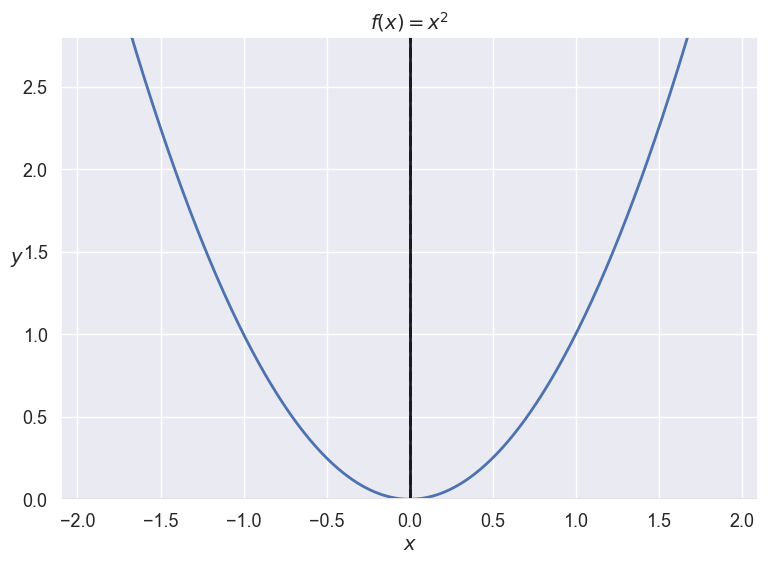

In [14]:
#@title
xs = np.linspace(-2.1, 2.1, 500)
ys = xs**2
plt.plot(xs, ys)

plt.plot([0, 0], [0, 3], "k--")
#plt.arrow(-1.4, 2.5, 0.5, -1.3, head_width=0.1,color='b')
#plt.arrow(0.85, 1.05, 0.5, 1.3, head_width=0.1,color='b')

show([-2.1, 2.1, 0, 2.8], title="$f(x) = x^2$")

Si queremos estudiar el crecimiento/decrecimiento de la funcion en un puntop A en el grafico de la funcion con  coordenadas $(x, f(x))$, Podemos mirar  una  *recta que sea tangente  al grafico en ese punto A**. Recordemos que la **Pendiente A**. de una recta nos da informacion acerca de si la recta crece o decrece.

La pendiente de una recta (no vertical) se puede calcular tomando dos puntos cualquiera $\mathrm{A}$ y $\mathrm{B}$ en la linea y calculando el **cociente incremental**, es decir el cociente entre la variacion en el eje $x$ ($\Delta x$) y la variación en el eje $y$ ($\Delta y$):  

$pendiente = \dfrac{\Delta y}{\Delta x} = \dfrac{y_\mathrm{B} - y_\mathrm{A}}{x_\mathrm{B} - x_\mathrm{A}} = \dfrac{f(x_\mathrm{B}) - f(x_\mathrm{B})}{x_\mathrm{B} - x_\mathrm{A}}$

In [15]:
#@title Ejemplo con la función cuadrática
'''def get_AB_line(A_pos, B_pos, x_min=-1000, x_max=+1000):
    rise = B_pos[1] - A_pos[1]
    run = B_pos[0] - A_pos[0]
    slope = rise / run
    offset = A_pos[1] - slope * A_pos[0]
    return [x_min, x_max], [x_min * slope + offset, x_max * slope + offset]

def plot_AB_line(A_pos, B_pos, A_name="A", B_name="B"):
    for point, name in ((A_pos, A_name), (B_pos, B_name)):
        plt.plot(point[0], point[1], "bo")
        plt.text(point[0] - 0.35, point[1], name, fontsize=14)
    xs, ys = get_AB_line(A_pos, B_pos)
    plt.plot(xs, ys)

def plot_rise_over_run(A_pos, B_pos):
    plt.plot([A_pos[0], B_pos[0]], [A_pos[1], A_pos[1]], "k--")
    plt.text((A_pos[0] + B_pos[0]) / 2, A_pos[1] - 0.4, "run", fontsize=14)
    plt.plot([B_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], "k--")
    plt.text(B_pos[0] + 0.2, (A_pos[1] + B_pos[1]) / 2, "rise", fontsize=14)

def animate_AB_line(f, fp, f_str, x_A, axis=None):
    y_A = f(x_A)
    eps = 1e-4
    x_B_range = 1.5
    x_B = x_A + eps

    n_frames = 200
    text_offset_A = -0.2
    text_offset_B = +0.1
    x_min, x_max = -1000, 1000

    fig, ax = plt.subplots()

    # plot f(x)
    xs = np.linspace(-2.1, 2.1, 500)
    ys = f(xs)
    ax.plot(xs, ys)

    # plot the tangent to the curve at point A
    if fp:
        slope = fp(x_A)
        offset = y_A - slope * x_A
        ax.plot([x_min, x_max], [slope*x_min + offset, slope*x_max + offset],
                "y--")

    # plot the line AB and the labels A and B so they can be animated
    y_A = f(x_A)
    y_B = f(x_B)
    xs, ys = get_AB_line([x_A, y_A], [x_B, y_B])
    line_inf, = ax.plot(xs, ys, "-")
    line_AB, = ax.plot([x_A, x_B], [y_A, y_B], "bo-")
    ax.text(x_A + text_offset_A, y_A, "A", fontsize=14)
    B_text = ax.text(x_B + text_offset_B, y_B, "B", fontsize=14)

    # plot the grid and axis labels
    title = r"Pendiente de la curva $y = {}$ en $x_\mathrm{{A}} = {}$".format(f_str, x_A)
    show(axis or [-2.1, 2.1, 0, 2.8], title=title)

    def update_graph(i):
        x_B = x_A + x_B_range * np.cos(i * 2 * np.pi / n_frames) ** 3
        if np.abs(x_B - x_A) < eps:
            x_B = x_A + eps # to avoid division by 0
        y_B = f(x_B)
        xs, ys = get_AB_line([x_A, y_A], [x_B, y_B])
        line_inf.set_data(xs, ys)
        line_AB.set_data([x_A, x_B], [y_A, y_B])
        B_text.set_position([x_B + text_offset_B, y_B])
        return line_inf, line_AB

    anim = animation.FuncAnimation(fig, update_graph,
                                  init_func=lambda: update_graph(0),
                                  frames=n_frames,
                                  interval=20,
                                  blit=True)
    plt.close()
    return anim

animate_AB_line(lambda x: x**2, lambda x: 2*x, "x^2", -1)'''
# Descomentar las ''' para correr las funciones  

'def get_AB_line(A_pos, B_pos, x_min=-1000, x_max=+1000):\n    rise = B_pos[1] - A_pos[1]\n    run = B_pos[0] - A_pos[0]\n    slope = rise / run\n    offset = A_pos[1] - slope * A_pos[0]\n    return [x_min, x_max], [x_min * slope + offset, x_max * slope + offset]\n\ndef plot_AB_line(A_pos, B_pos, A_name="A", B_name="B"):\n    for point, name in ((A_pos, A_name), (B_pos, B_name)):\n        plt.plot(point[0], point[1], "bo")\n        plt.text(point[0] - 0.35, point[1], name, fontsize=14)\n    xs, ys = get_AB_line(A_pos, B_pos)\n    plt.plot(xs, ys)\n\ndef plot_rise_over_run(A_pos, B_pos):\n    plt.plot([A_pos[0], B_pos[0]], [A_pos[1], A_pos[1]], "k--")\n    plt.text((A_pos[0] + B_pos[0]) / 2, A_pos[1] - 0.4, "run", fontsize=14)\n    plt.plot([B_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], "k--")\n    plt.text(B_pos[0] + 0.2, (A_pos[1] + B_pos[1]) / 2, "rise", fontsize=14)\n\ndef animate_AB_line(f, fp, f_str, x_A, axis=None):\n    y_A = f(x_A)\n    eps = 1e-4\n    x_B_range = 1.5\n    x_B = x

Esto nos lleva a una definición formal de la derivada $f'(x_\mathrm{A})$ como el límite de este **cociente incremental** cuando hacemos que el punto $x_\mathrm{B} \rightarrow x_\mathrm{A}$
<hr />

La **derivada** de una función $f(x)$ en $x = x_\mathrm{A}$ esta definida como:

\begin{equation}
\partial_x f(x_\mathrm{A}) = \underset{x_\mathrm{B} \to x_\mathrm{A}}\lim\dfrac{f(x_\mathrm{B}) - f(x_\mathrm{A})}{x_\mathrm{B} - x_\mathrm{A}}
\end{equation}

Podemos a su vez, reescribirla de la siguiente manera:

\begin{equation}
\partial_x f(x_\mathrm{A}) = \underset{h \to 0}\lim\dfrac{f(x_\mathrm{A}+h) - f(x_\mathrm{A})}{h}
\end{equation}

<hr />

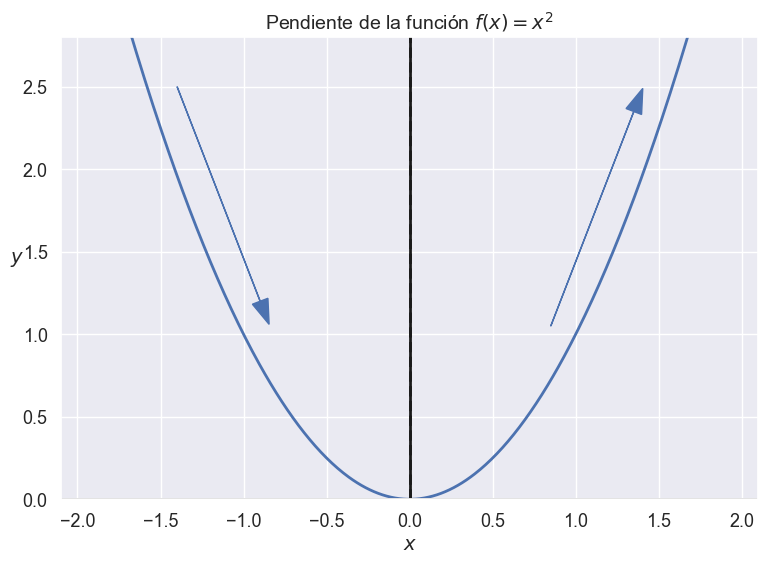

In [16]:
#@title
xs = np.linspace(-2.1, 2.1, 500)
ys = xs**2
plt.plot(xs, ys)

plt.plot([0, 0], [0, 3], "k--")
plt.arrow(-1.4, 2.5, 0.5, -1.3, head_width=0.1,color='b')
plt.arrow(0.85, 1.05, 0.5, 1.3, head_width=0.1,color='b')
show([-2.1, 2.1, 0, 2.8], title="Pendiente de la función $f(x) = x^2$")

Volvamos al ejemplo de $f(x)=x^2$. ¿Que esperariamos que suceda con la derivada de f en otros puntos?: 

- a la izquierda del eje $y$ (es decir, cuando $x<0$), la pendiente es negativa (es decir, cuando nos movemos de izquierda a derecha, la curva desciende), 
- a la derecha del eje $y$ (es decir, cuando $x>0$) la pendiente es positiva (es decir, cuando nos movemos de izquierda a derecha, la curva sube)
- en el punto $x=0$, la pendiente es igual a 0 (es decir, la curva es localmente plana)

El hecho de que la pendiente sea 0 cuando alcanzamos un mínimo (o incluso un máximo) es de crucial importancia para  entender como encontrar puntos los minimos/máximos de una función. Esto último será también muy relevante en el futuro para entender como se *entrenan* los modelos en Machine Learning y Deep Learning.

En el siguiente widget pueden ver de nuevo el gráfico de la función cuadrática y junto a su función derivada y probar con otras funciones con sus respectivas derivadas.

In [17]:
# @markdown Widget para visualizar una función y su derivada
function_options = widgets.Dropdown(
    options=['Cuadrática', 'Lineal', 'Seno', 'Explonencial', 'Sigmoidea'],
    description='Función',
    disabled=False,
)

derivative = widgets.Checkbox(
    value=False,
    description='Ver derivada',
    disabled=False,
    indent=False
)

integral = widgets.Checkbox(
    value=False,
    description='Ver primitiva',
    disabled=True,
    indent=False
)

def on_value_change(change):
    derivative.value = False
    integral.value = False

function_options.observe(on_value_change, names='value')

#interact(plot_functions, function = function_options, 
# show_derivative = derivative, show_integral = integral);
interact(plot_functions, function = function_options, show_derivative = derivative,
         show_integral = integral);

interactive(children=(Dropdown(description='Función', options=('Cuadrática', 'Lineal', 'Seno', 'Explonencial',…

**¿Todas las funciones pueden ser derivadas?** Lamentablemente no todas las funciones pueden ser derivadas. Existen condiciones para determinar si una función es derivable o no. Un ejemplo es la función $f(x)=|x|$, esta función no tiene derivada en $x=0$ ya que no existe el límite ahí. En general las funciones que tienen derivadas en todo su dominio se dicen que son funciones **derivables**, **suaves** o de clase $\mathcal{C}^1$ si además esa derivada es continua. No entraremos mas en detalle en estas condiciones pero dejaremos una referencias para profundizar en el tema.


---
## 2.1 - Derivación analítica

Cuando calculamos la derivada analíticamente, estamos encontrando la fórmula exacta para la función derivada. Para hacer esto, en lugar de tener que tener que calcular el cociente incremental cada vez, podemos utilizar las distintas propiedades de la derivada en combinación con derivadas que ya conocemos, a menudo podemos consultar [una tabla](https://en.wikipedia.org/wiki/Differentiation_rules) para obtener una lista de derivadas comunes, en este caso nuestro amigo de confianza Wikipedia. Aca les dejamos una tabla con derivadas que incluye las reglas que estaremos viendo mas adelante.

|                  | Función $f$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Derivada $f'$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
| ---------------- |------------------- | ------------------------------- |
| **Constante**     | $f(x) = c$         | $f'(x) = 0$                     |
| **Suma**          | $f(x) = g(x) + h(x)$ | $f'(x) = g'(x) + h'(x)$       |
| **Producto**      | $f(x) = g(x) h(x)$ | $f'(x) = g(x)h'(x) + g'(x)h(x)$ |
| **Cociente**     | $f(x) = \dfrac{g(x)}{h(x)}$ | $f'(x) = \dfrac{g'(x)h(x) - g(x)h'(x)}{h^2(x)}$ |
| **Potencia**        | $f(x) = x^r$ con $r \neq 0$ | $f'(x) = rx^{r-1}$    |
| **Exponencial**  | $f(x) = \exp(x)$   | $f'(x)=\exp(x)$                 |
| **Logaritmo**    | $f(x) = \ln(x)$    | $f'(x) = \dfrac{1}{x} $         |
| **Seno**          | $f(x) = \sin(x)$   | $f'(x) = \cos(x) $              |
| **Coseno**          | $f(x) = \cos(x)$   | $f'(x) = -\sin(x) $             |
| **Tangente**          | $f(x) = \tan(x)$   | $f'(x) = \dfrac{1}{\cos^2(x)}$  |
| **R. de la Cadena**   | $f(x) = g(h(x))$ | $f'(x) = g'(h(x))\,h'(x)$  |


Por ejemplo, si quisieramos encontrar la derivada de $f(x) = x^3$, podrías consultar ese sitio (o cualquier tabla de derivadas) y encontrar en la Sección 2.1, que si $f$ es una función que tiene la forma de $f(x) = x^n$ para algún valor $n$, entonces $\frac{df}{dx}(x) = nx^{n-1}$. Entonces pueden llegar a calcular la derivada de $f(x) = x^3$ que es $\frac{df}{dx}(x) = 3x^{2}$.

Esta lista de derivadas comunes a menudo contiene solo funciones muy simples. Afortunadamente, como veremos en las próximas dos secciones, a menudo podemos descomponer la derivada de una función compleja en derivadas de componentes más simples.

---
### 2.1.0 - Linearidad de la derivada

La derivada tiene la propiedad de ser un **operador lineal**. Esto implica que si queremos derivar una suma de funciones (asumamos que existen las derivadas de las funciones $f$ y $g$) y estan multiplicadas por constantes $\alpha, \beta \in \mathbb{R}$, entonces:

\begin{equation}
\frac{d}{dx} (\alpha\cdot f(x) + \beta\cdot g(x)) = \alpha\cdot \frac{df}{dx}(x)  + \beta\cdot \frac{dg}{dx}(x)
\end{equation}

Por ejemplo, supongamos que queremos derivar la función $f(x)=\dfrac{1}{4}x^4 - x^2 + \dfrac{1}{2}$. 

Usando la linearidad de la derivada y la tabla podemos calcularla:

\begin{align}
\frac{d}{dx}f(x) &= \frac{d}{dx}\bigg(\dfrac{1}{4}x^4 - x^2 + \dfrac{1}{2}\bigg)\\
&= \dfrac{1}{4} \frac{d}{dx}\bigg(x^4 \bigg)- \frac{d}{dx}\bigg( x^2 \bigg)+ \frac{d}{dx} \bigg(\dfrac{1}{2}\bigg)
\\
&= \dfrac{1}{4} 4x^3- 2x + 0
\\
&= x^3- 2x
\end{align}

---
### 2.1.1 - Regla del producto
Para el caso en el que $f$ es una función que es producto de otras dos funciones: $f(x) = u(x)\cdot v(x)$, entonces podemos calcular $\frac{df}{dx}$ como:

\begin{equation}
\frac{df}{dx}(x) = v(x)\cdot \frac{du}{dx}(x) + u(x)\cdot \frac{dv}{dx}(x)
\end{equation}

#### Ejericicio de programación 2.1.1

Veamos un ejemplo aplicado a una funcion del mundo real. Usemos la regla del producto para obtener la derivada de la [función alfa del potencial postsináptico](https://es.wikipedia.org/wiki/Potencial_postsin%C3%A1ptico). Esta funcion mide como se polariza la membrana de las neurona durante la interaccino de la [sinapsis](https://es.wikipedia.org/wiki/Sinapsis). La forma del potencial postsináptico viene dada por la llamada función alfa que depende del tiempo:

\begin{equation}
f(t) = t \cdot \text{exp}\left( -\frac{t}{\tau} \right)
\end{equation}

Aquí $f(t)$ es un producto de $t$ y $\text{exp} \left(-\frac{t}{\tau} \right)$. Entonces podemos tener $u(t) = t$ y $v(t) = \text{exp} \left( -\frac{t}{\tau} \right)$ y usar la regla del producto.

Hemos definido $u(t)$ y $v(t)$ en el siguiente código, en términos de la variable $t$, que es un `array` de pasos de tiempo de 0 a 10. Defina $\frac{du}{dt }$ y $\frac{dv}{dt}$, calculan la derivada completa de la función alfa usando la regla del producto.

*Sugerencia*

$\dfrac{d}{dx}\text{exp}(k\cdot x) = k \cdot \text{exp}(k\cdot x)$  

In [18]:
########################################################################
## TODO
## completar los ... abajo y eliminar la linea que sigue
raise NotImplementedError("Calculen las derivadas")
########################################################################

# creamos una grilla de valores a evaluar con un tau constante
t = np.arange(0, 10, .1)
tau = 0.5

# calculamos la función sobre la grilla
f = t * np.exp(-t/tau)

# definimos las funciones u(t), v(t)
u_t = t
v_t = np.exp(-t/tau)

# definimos las derivadas de cada función du/dt, dv/dt
du_dt = ...
dv_dt = ...


# definimos la derivada completa
df_dt = ...

# Visualiza
plot_alpha_func(t, f, df_dt)

NotImplementedError: Calculen las derivadas

---
### 2.1.2 - Regla de la cadena

Muchas veces nos encontramos con situaciones en las que la variable $x$ cambia con otra variable, por ejemplo el tiempo ($t$), y afecta a nuestra función $f$. ¿Cómo podemos estimar la derivada de $f$ con respecto a $t$, es decir, $\frac{df}{dt} = ?$ 

Para calcular $\frac{df}{dt}$ podemos usar la [Regla de la Cadena](https://es.wikipedia.org/wiki/Regla_de_la_cadena). Esta regla nos dice como podemos calcular la derivada de una función que $h$ que es el resultado de **componer dos funciones** $f$ y $g$: $h(x)=(f \circ g) (x) = f(g(x))$, entonces la derivada de $h$ respecto de $x$ es:

\begin{equation}
\frac{dh}{dx}(x) = \frac{d(f \circ g)}{dx}(x) = \frac{df}{dg}(g)\cdot\frac{dg}{dx}(x)
\end{equation}

En nuestro pequeño ejemplo del principio tenemos que $f$ era una función que depende de $x$ que a su vez depende de $t$, por lo tanto si quieramos 

\begin{equation}
\frac{df}{dt} = \frac{df}{dx}\cdot\frac{dx}{dt}
\end{equation}

Un ejemplo muy sencillo sería el siguiente:

$u(t)= \text{exp}(-3\cdot t)$

Para poder derivar nuestra función $u$ tenemos que ser capaces de escribirlo como una composición de funciones (una funcion adentro de la otra). Lo mas sencillo sería pensar que lo que esta adentro de la exponencial es una función y la exponencial es otra:

$f(x) = \text{exp}(x) \text{     y     } g(x)=-3\cdot x$

Por lo tanto podemos escribir a $u(t) = f(g(t)) = (f\circ g)(t)$ y usar la regla de la cadena para obtener la derivada

#### Ejercicio teórico 2.1.2

Supongamos que tenemos la siguiente función

\begin{equation}
r(a) = e^{a^4 + 1}
\end{equation}

¿Cuanto da $\frac{dr}{da}$? Esta es una función más compleja por lo que no podemos simplemente consultar una tabla de derivadas comunes. ¿Puedes usar la regla de la cadena para ayudar?

**Sugerencia:** La idea para usar la regla de la cadena es encontrar una función intermedia para llevarlo a la forma en la que aparece la regla.

**Bonus** En general hay una regla de derivación mas que se suele enseñar en conjunto a las dos recién vistas, la regla de la división para derivadas.

---
### 2.2.3 - Derivadas de orden superior

Como la función derivada es nuevamente una función, podríamos querer derivarla nuevamente para entender como es que ahora varía la derivada. Esto se conoce como la **segunda derivada** o derivada de **segundo orden** y lo escribiremos asi:

\begin{equation}
\dfrac{d}{dx} \bigg(\dfrac{df}{dx}\bigg) = \dfrac{d^2f}{dx^2} = f'' 
\end{equation}

Estas derivadas pueden volver a ser derivadas tantas veces como sea posible, por lo cual tenemos derivadas de otros ordenes: $\dfrac{d}{dx} \dfrac{d}{dx} \bigg(\dfrac{df}{dx}\bigg) = \dfrac{d^3f}{dx^3}$ y asi sucesivamente. Estas derivadas se suelen conocer como derivadas de **orden superior** o derivadas **sucesivas**.

#### Ejercicio teórico 2.2.3

Observar que sucede con las derivadas de orden superior para la función $f(x)=sen(x)$. Para esto calcular $\dfrac{df}{dx}$, $\dfrac{d^2f}{dx^2}$, $\dfrac{d^3f}{dx^3}$ y $\dfrac{d^4f}{dx^4}$. 

¿Puede observar un patrón? Calcular la derivada $\dfrac{d^{27}f}{dx^{27}}$.

---
### 2.2.4 - Derivación simbólica en Python: SymPy

![imagen.png](https://docs.sympy.org/latest/_static/sympylogo.png)

Existe una librería que nos permite calcular las derivadas de manera simbólica: [SymPy](https://docs.sympy.org/latest/tutorial/index.html#tutorial). Esta librería nos provee de simbolos y [funciones](https://docs.sympy.org/latest/modules/functions/index.html) que nos permiten crear *expresiones simbólicas* las cuales podemos derivar, evaluar, integrar, graficar y más.

Veamos un ejemplo:

In [19]:
# SymPy utiliza un tipo de objeto que son los símbolos que representarán variables
# import sympy as sp
f, t = sp.symbols('f, t')

# Para definir las funciones tenemos que utilizar el módulo de funciones que tiene SymPy
f = 1/(1 + sp.exp(-(t-5)))

# La función "derivar" podemos
diff_f = sp.diff(f)

# Imprimimos la derivada
print('La derivada de', f, 'es ', diff_f)

La derivada de 1/(exp(5 - t) + 1) es  exp(5 - t)/(exp(5 - t) + 1)**2


In [20]:
# Ademas podemos utilizar la clase Derivative que nos permite declarar una derivada
# a partir de la función y los simbolos respectos a los cuales derivamos y cuántas veces
deriv_f = sp.Derivative(f, t)

deriv_f

Derivative(1/(exp(5 - t) + 1), t)

In [21]:
# A diferencia de sp.diff, Derivative nos construye la función derivada pero no la 
# "evalua", para eso tenemos que decirle que lo haga con el método doit
deriv_f.doit()

exp(5 - t)/(exp(5 - t) + 1)**2

In [22]:
# Podemos derivar dos veces con Derivative
deriv_f_2 = sp.Derivative(f,t,t)
deriv_f_2.doit()

(-exp(5 - t) + 2*exp(10 - 2*t)/(exp(5 - t) + 1))/(exp(5 - t) + 1)**2

Si queremos poder evaluar numéricamente una expresion de SymPy debemos pasarla primero a NumPy ya que las expresiones simbólicas no nos permiten hacerlo:

In [23]:
# Lambdify nos dejará convertir una expresión de sympy a numpy
diff_f_numpy = sp.lambdify(t, diff_f, 'numpy')
diff_f_numpy(5)
diff_f_numpy(np.arange(0,10,1))

array([0.00664806, 0.01766271, 0.04517666, 0.10499359, 0.19661193,
       0.25      , 0.19661193, 0.10499359, 0.04517666, 0.01766271])

Si queremos graficar nuestras funciones, no es necesario pasarnos a Numpy para hacerlo numéricamente, podemos usar SymPy para graficar con el módulo `plot` varias expresiones, creando un objeto al cuál podremos ir agregandole otros gráficos:

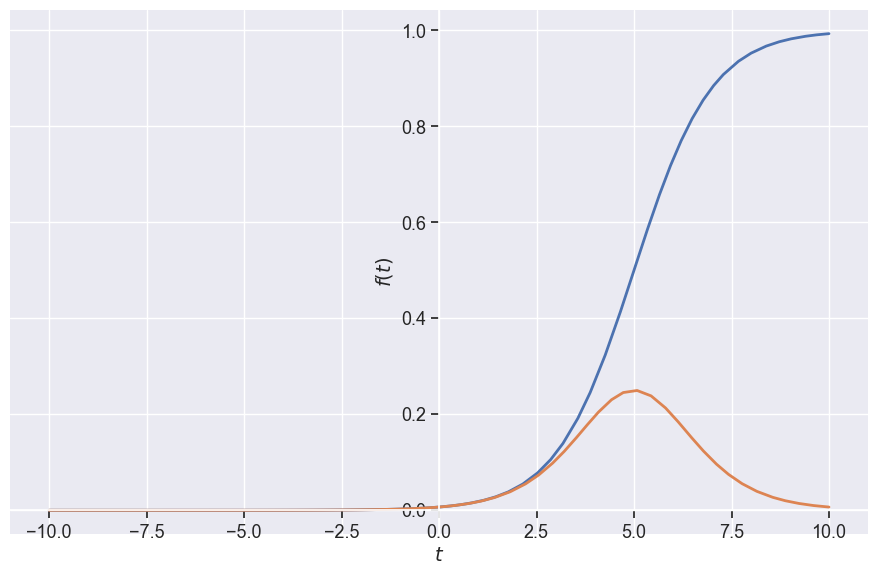

In [24]:
x = sp.symbols('x')
# Como vamos a agregarle varios plots al gráfico usamos show=False
p1 = sp.plot(f, show=False)
p2 = sp.plot(diff_f,show=False)

p1.extend(p2)

p1.show()

Puede volver al widget visto en la sección 2.0 y ver son los gráficos de la función sigmoide y su derivada y ver que son efectivamente las mismas.

#### Ejercicio de programación 2.2.4

Utilizando SymPy compruebe los resultados de derivar el Potencial Postsináptico del ejericio 2.1.2 y grafiquelos.

In [ ]:
########################################################################
## TODO 
## completar los ... abajo y eliminar la linea que sigue
raise NotImplementedError("Calculen las derivadas")
########################################################################

# declaramos los simbolos necesarios
...

# creamos la funcion para el potencial psp
psp = ...

# calculamos su derivada
diff_psp = ...

### 2.2.5 - Automatic Differentiation

Hoy en día existen librerías que nos permiten calcular derivadas de manera automática: [*Automatic Differentiation*](https://en.wikipedia.org/wiki/Automatic_differentiation). Las dos herramientas más populares de Deep Learning, [PyTorch](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) y [TensorFlow](https://www.tensorflow.org/guide/autodiff), aplican estas técnicas para ir calculando las derivadas de los modelos a medida que se van construyendo.

---

## 2.2: Derivación numérica

Formalmente, la derivada de una función $\mathcal{f}(x)$ en cualquier valor $a$ puede aproximarse por el cociente incremental en un entorno del valor $a$ acercandonos al mismo por un valor $h>0$. Esto se conoce como [*diferencia finita*](https://www.wikiwand.com/es/Diferencia_finita) (DF):

\begin{equation}
DF_h(a) = \frac{f(a+h) - f(a)}{h} \sim \partial f(a)
\end{equation}

Cuando $h\rightarrow 0$, la DF se aproxima al valor real de la derivada. Comprobemos esto.

### Widget interactivo: Derivando numéricamente el seno

A continuación, encontramos la derivada numérica de la función seno para diferentes valores de $h$ y comparamos el resultado con la solución analítica.

- ¿Qué valores de h resultan en derivadas numéricas más precisas?

In [25]:
# @markdown *Ejecute esta celda para habilitar el widget.*
def numerical_derivative_demo(h = 0.2):
  # Now lets create a sequence of numbers which change according to the sine function
  dt = 0.01
  tx = np.arange(-10, 10, dt)
  sine_fun = np.sin(tx)

  # symbolic diffrentiation tells us that the derivative of sin(t) is cos(t)
  cos_fun = np.cos(tx)

  # Numerical derivative using difference formula
  n_tx = np.arange(-10,10,h) # create new time axis
  n_sine_fun = np.sin(n_tx) # calculate the sine function on the new time axis
  sine_diff = (n_sine_fun[1:] - n_sine_fun[0:-1]) / h

  fig = plt.figure()
  ax = plt.subplot(111)
  plt.plot(tx, sine_fun, label='seno')
  plt.plot(tx, cos_fun, label='derivada analítica')

  #with plt.xkcd():
    # notice that numerical derivative will have one element less
  plt.plot(n_tx[0:-1], sine_diff, label='derivada numérica')
  plt.xlim([-10, 10])
  plt.xlabel('x')
  plt.ylabel('f(x) o df(x)/dx')
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
            ncol=3, fancybox=True)
  plt.show()

_ = widgets.interact(numerical_derivative_demo, h = (0.01, 0.5, .02))

interactive(children=(FloatSlider(value=0.2, description='h', max=0.5, min=0.01, step=0.02), Output()), _dom_c…

# 3 - Cálculo diferencial en varias variables

## 3.0 - Funciones en varias variables 

En los problemas de la vida real, las funciones tendrán mas de una variable o incluso podrían tener mas de una sola salida. Para representar estas funciones necesitaremos recurrir a los conocimientos que obtuvimos en la clase anterior: *vectores* y *matrices*. Miremos el siguiente ejemplo:

\begin{equation}
h(t) = (h_1(t), h_2(t)) = (t^4, \text{exp}(-t))
\end{equation}

En este caso estamos viendo una función que recibe una variable de entrada y devuele dos valores, por lo tanto podemos escribir que:

\begin{align}
h: \mathbb{R} &\rightarrow \mathbb{R^2} \\
t &\mapsto (t^4, \text{exp}(-t))
\end{align}

Pero también pude suceder que en vez de tomar una sola entrada, nuestra función tome mas de una:

\begin{align}
f(x,y) &= x^2 + 2xy + y^2\\
f&: \mathbb{R^2} \rightarrow  \mathbb{R}
\end{align}

Es decir que en general la candidad de entradas puede ser tan grande o arbitraria como querramos $x_1,x_2,\dots,x_n$ y lo mimso vale para las salidas $f_1,f_2,\dots, f_m$. **En lo que queda de este curso nos concentraremos principalmente en funciones que tengan solo una salida: "funciones escalares", y asumiremos que todas las funciones son de este estilo salvo que se aclare lo contrario.**. 

Escribiremos a $f$ como una función que toma como entradas $n$ variables que podemos representar como un vector columna y escribirlo como $\mathbf{x}$ para facilitarnos la notación:

\begin{equation}
\mathbf{x}=\begin{pmatrix}
x_1\\
x_2\\
\vdots\\
x_n
\end{pmatrix}
\end{equation}

Entonces podemos ahora escribir esto como:

\begin{align}
f: \mathbb{R}^n &\rightarrow \mathbb{R} \\
\mathbf{x} &\mapsto f(\mathbf{x})
\end{align}

Y ahora veamos como las podemos derivar!

---
## 3.1 - Derivadas parciales 

La definición de derivada no cambia con respecto a lo que veniamos viendo, solo que ahora tendremos que decir respecto a que variables estamos mirando el cambio de la función. Cuando tomamos la derivada de una función multivariable con respecto a una de las variables, se llama **derivada parcial**. Por ejemplo si tenemos una función:

\begin{align}
f(x,y) = x^2 + 2xy + y^2
\end{align}

Entonces las derivadas parciales de esta función serían dos, una con respecto a $x$ y otra con respecto a $y$:

\begin{align}
\frac{\partial(f(x,y))}{\partial x} = 2x + 2y + 0 \\\\
\frac{\partial(f(x,y))}{\partial y} = 0 + 2x + 2y
\end{align}

En este caos, la derivada del último término ($y^2$) con respecto a $x$ es cero porque no cambia con respecto a $x$, es decir que para esta derivada ese término es igual a un término constante. De manera similar, la derivada de $x^2$ con respecto a $y$ también es cero.

Otra observación importante es que siguen valiendo todas las reglas que vimos hasta ahora: linearidad, producto de funciones y regla de la cadena.

Al igual que con las derivadas que vimos anteriormente, puedes obtener derivadas parciales a través de un método analítico (encontrar una ecuación exacta) o un método numérico (aproximar).

---
### 3.1.1: Visualizando derivadas parciales

En la demostración a continuación, pueden poner cualquier función de $x$ e $y$, como la escribiría en Python para luego visualizar tanto la función como las derivadas parciales.

Visualizamos la función bidimensional (dos entradas, una salida) como un gráfico de superficie en el que los valores de la función se muestran en color. El amarillo representa un valor alto y el azul representa un valor bajo. La altura de la superficie también muestra el valor numérico de la función. Una descripción más completa de los gráficos de superficie 2D y por qué los necesitamos se encuentra en la Sección adicional 1.1. El primer gráfico es la de nuestra función. Y los dos gráficos inferiores son las superficies derivadas con respecto a (c.r.a.) las variables $x$ y $y$, $\frac{df}{dx}$ y $\frac{df}{dy}$ respectivamente.

1. Asegúrese de comprender cómo se relacionan los gráficos entre sí; si no, revise el material anterior
2. ¿Puedes pensar en una función en la que la derivada parcial con respecto a x sea un plano lineal y la derivada con respecto a y tenga más curvatura?
3. ¿Qué sucede con las derivadas parciales si no hay términos que impliquen multiplicar $x$ y $y$ juntos?

In [26]:
# @markdown Widget para habilitar la demo

# Usemos sympy para calcular derivadas parciales de funciones de 2 variables
@interact(f2d_string = 'x**2 + 2*x*y + y**2')
def plot_partial_derivs(f2d_string):
  f, x, y = sp.symbols('f, x, y')

  f2d = eval(f2d_string)
  f2d_dx = sp.diff(f2d,x)
  f2d_dy = sp.diff(f2d,y)

  print('La derivada parcial de ', f2d, 'con respecto a x es', f2d_dx)
  print('La derivada parcial de ', f2d, 'con respecto a y es', f2d_dy)

  p1 = sp.plotting.plot3d(f2d, (x, -5, 5), (y, -5, 5),show=True,xlabel='x', ylabel='y', zlabel='f(x,y)',title='Nuestra función')

  p2 = sp.plotting.plot3d(f2d_dx, (x, -5, 5), (y, -5, 5),show=True,xlabel='x', ylabel='y', zlabel='df(x,y)/dx',title='Derivada c.r.a. x')

  p3 = sp.plotting.plot3d(f2d_dy, (x, -5, 5), (y, -5, 5),show=True,xlabel='x', ylabel='y', zlabel='df(x,y)/dy',title='Derivada c.r.a. y')

interactive(children=(Text(value='x**2 + 2*x*y + y**2', description='f2d_string'), Output()), _dom_classes=('w…

---
### 3.1.2 El Gradiente

El gradiente de la función $f(\mathbf{x})$ en algún punto $\mathbf{x}_\mathrm{A}$ es el vector cuyas componentes son todas las derivadas parciales de la función en ese punto. Se escribe $\nabla f(\mathbf{x}_\mathrm{A})$:

$\nabla f(\mathbf{x}_\mathrm{A}) = \begin{pmatrix}
\dfrac{\partial f}{\partial x_1}(\mathbf{x}_\mathrm{A})\\
\dfrac{\partial f}{\partial x_2}(\mathbf{x}_\mathrm{A})\\
\vdots\\\
\dfrac{\partial f}{\partial x_n}(\mathbf{x}_\mathrm{A})\\
\end{pmatrix}$

Ahora, esto podemos ver como calcularlo en SymPy:

In [27]:
# definamos primero nuestra función y simbolos
x1, x2, x3, f = sp.symbols('x1, x2, x3, f')
f = 2*x1*x2 - sp.exp(x3) + x1*x3**4

# si queremos saber la derivada diff nos pedira la variable con respecto a la cual derivar
diff_f = sp.diff(f,x3)

# Imprimimos la derivada con respecto a x3
print('La derivada de', f, 'con respecto a x3 es ', diff_f)

La derivada de 2*x1*x2 + x1*x3**4 - exp(x3) con respecto a x3 es  4*x1*x3**3 - exp(x3)


In [28]:
# si queremos calcular el gradiente tendremos que calcular cada derivada parcial
# para esto debemos conseguir los "simbolos libres" de la expresión
print(f.free_symbols)

# tengan cuidado ya que si nuestra función es independiente de un termino no aparecerá
# como símbolo libre
g = sp.symbols('g')
g = sp.sqrt(x1) - x2**3
print(g.free_symbols)

{x2, x3, x1}
{x2, x1}


In [29]:
# ahora podemos conseguir nuestro gradiente de una manera directa
grad_f = [f.diff(x) for x in f.free_symbols]
print(grad_f)

# otra forma de hacerlo es con derive_by_array
grad_f_bis = sp.derive_by_array(f, (x1, x2, x3))
print(grad_f_bis)

# hay que tener cuidado que el orden no es necesariamente el mismo

[2*x1, 4*x1*x3**3 - exp(x3), 2*x2 + x3**4]
[2*x2 + x3**4, 2*x1, 4*x1*x3**3 - exp(x3)]


**Intepretación geométrica**

El gradiente es una generalización de lo que antes llamamos la derivada de una función de una sola variable, solo que esta vez la "derivada" tiene mas dimensiones que dependen de la cantidad de salidas que tenga nuestra función. En esos casos la derivada representaba la pendiente de una recta que aproximaba localmente a la función. Al pasar a muchas dimensiones, solemos perder la intuición de lo que esta sucediendo ya que es dificil de visualizar. Sin embargo, la idea es muy similar, pero en vez de tener una recta tenemos la versión generalizada, que es un plano. En la imagen vemos el gráfico de una función $f(x,y)$ como una superficie celeste y un punto $P$, donde calculamos cuanto vale el $\nabla f$ ahí [1].

![image.png](https://skeptric.com/images/tangent_plane.png)

En vez de tener una **recta tangente** como vimos en el ejemplo de la función cuadrática, tendremos **un plano tangente** que esta caracterizado por ese punto y un vector normal (perpendicular) a la superficie. Asi como la derivada $f'$ era la pendiente de la recta, en este caso $\nabla f$ será la normal del plano.

Además, el gradiente tiene una característica que será muy relevante para los algortimos de optimización usados en Deep Learning, el mismo **apunta en la dirección de máximo crecimiento de la función**. Esto quiere decir que si uno quisiera saber haciendo donde moverse en el gráfico de la función para seguir subiendo lo más posible estando parado en $f(\mathbf{x}_0)$, deberia seguir la dirección en la que apunte $\nabla f(\mathbf{x}_0)$. A su vez, implica que seguir la dirección de máximo decrecimiento será $-\nabla f(\mathbf{x}_0)$.

[1] Imagen tomada de: https://skeptric.com/derivative/

Hasta ahora solo hemos considerado funciones que generan un escalar, pero en su lugar es posible generar vectores. Por ejemplo, una red neuronal de clasificación normalmente genera una probabilidad para cada clase, por lo que si hay $m$ clases, la red neuronal generará un vector dimensional $d$ para cada entrada.

En Deep Learning, generalmente solo necesitamos calcular la derivada(gradiente) de la función de pérdida, que casi siempre genera un solo número escalar. Pero supongamos por un segundo que desea diferenciar una función $\mathbf{f}(\mathbf{x})$ que genera vectores $d$-dimensionales. La buena noticia es que puede tratar cada dimensión de _salida_ independientemente de las demás. Esto le dará una derivada parcial para cada dimensión de entrada y cada dimensión de salida. Si los pone a todos en una sola matriz, con una columna por dimensión de entrada y una fila por dimensión de salida, obtiene la llamada **matriz jacobiana**.

$
\mathbf{J}_\mathbf{f}(\mathbf{x}_\mathbf{A}) = \begin{pmatrix}
\dfrac{\partial f_1}{\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial f_1}{\partial x_2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial f_1}{\partial x_n}(\mathbf{x}_\mathbf{A})\\
\dfrac{\partial f_2}{\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial f_2}{\partial x_2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial f_2}{\partial x_n}(\mathbf{x}_\mathbf{A})\\
\vdots && \vdots && \ddots && \vdots \\
\dfrac{\partial f_m}{\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial f_m}{\partial x_2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial f_m}{\partial x_n}(\mathbf{x}_\mathbf{A})
\end{pmatrix}
$

---
## 3.3 - El Hessiano (*)

Volvamos a una función $f(\mathbf{x})$ que toma un vector $n$-dimensional como entrada y genera un escalar. Si determinas la ecuación de la derivada parcial de $f$ con respecto a $x_i$ (la componente $i^\text{th}$ de $\mathbf{x}$), obtendrás una nueva función de $\mathbf{x}$: $\dfrac{\partial f}{\partial x_i}$. Luego puede calcular la derivada parcial de esta función con respecto a $x_j$ (el componente $j^\text{th}$ de $\mathbf{x}$). El resultado es una derivada parcial de una derivada parcial: en otras palabras, es una **derivada parcial de segundo orden**, también llamada **Hessiana**. 

Se anota $\mathbf{x}$: $\dfrac{\partial^2 f}{\partial x_jx_i}$. Si $i\neq j$ entonces se llama **derivada parcial mixta de segundo orden**.
O bien, si $j=i$, se anota $\dfrac{\partial^2 f}{\partial {x_i}^2}$

Veamos un ejemplo: $f(x, y)=\sin(xy)$. Como mostramos anteriormente, las derivadas parciales de primer orden de $f$ son: $\dfrac{\partial f}{\partial x}=y\cos(xy)$ y $\dfrac{\partial f}{\partial y }=x\cos(xy)$. Entonces ahora podemos calcular todas los hessianos (usando las reglas derivadas que discutimos anteriormente):

* $\dfrac{\partial^2 f}{\partial x^2} = \dfrac{\partial f}{\partial x}\left[y\cos(xy)\right] = -y^2\sin(xy)$
* $\dfrac{\partial^2 f}{\partial y\,\partial x} = \dfrac{\partial f}{\partial y}\left[y\cos(xy)\right] = \cos(xy) - xy\sin(xy)$
* $\dfrac{\partial^2 f}{\partial x\,\partial y} = \dfrac{\partial f}{\partial x}\left[x\cos(xy)\right] = \cos(xy) - xy\sin(xy)$
* $\dfrac{\partial^2 f}{\partial y^2} = \dfrac{\partial f}{\partial y}\left[x\cos(xy)\right] = -x^2\sin(xy)$

Tenga en cuenta que $\dfrac{\partial^2 f}{\partial x\,\partial y} = \dfrac{\partial^2 f}{\partial y\,\partial x}$. Este es el caso siempre que todas las derivadas parciales sean definidas y continuas en una vecindad alrededor del punto en el que derivamos.

La matriz que contiene todas las hessianas se denomina **matriz hessiana**:

$
\mathbf{H}_f(\mathbf{x}_\mathbf{A}) = \begin{pmatrix}
\dfrac{\partial^2 f}{\partial {x_1}^2}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial^2 f}{\partial x_1\, \partial x_2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial^2 f}{\partial x_1\, \partial x_n}(\mathbf{x}_\mathbf{A})\\
\dfrac{\partial^2 f}{\partial x_2\,\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial^2 f}{\partial {x_2}^2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial^2 f}{\partial x_2\, \partial x_n}(\mathbf{x}_\mathbf{A})\\
\vdots && \vdots && \ddots && \vdots \\
\dfrac{\partial^2 f}{\partial x_n\,\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial^2 f}{\partial x_n\,\partial x_2}(\mathbf{x}_\mathbf{A})
&& \dots
&& \dfrac{\partial^2 f}{\partial {x_n}^2}(\mathbf{x}_\mathbf{A})\\
\end{pmatrix}
$

**Observación** Existen excelentes algoritmos de optimización que aprovechan las hessianas, pero en la práctica, Deep Learning casi nunca las usa. De hecho, si una función tiene $n$ variables, hay $n^2$ hessianos: dado que las redes neuronales suelen tener varios millones de parámetros, el número de hessianos superaría los miles de billones. Incluso si tuviéramos la cantidad necesaria de RAM, los cálculos serían prohibitivamente lentos.

---
# 4 - Cálculo integral

##  4.0 - Integración numérica

La diferenciación solo constituye la mitad del contenido del cálculo tradicional. El otro pilar, la integración o cálculo intergal, comienza pareciendo una pregunta bastante inconexa: "¿Cuál es el área debajo de esta curva?" Si bien aparentemente no tiene relación, la integración está estrechamente entrelazada con la diferenciación a través de lo que se conoce como el [*teorema fundamental del cálculo*](https://es.wikipedia.org/wiki/Teorema_fundamental_del_c%C3%A1lculo).

Para entonces poder calcular la integral la denotaremos como el área con el siguiente símbolo integral:

$$
\mathrm{Área}(\mathcal{A}) = \int_a^b f(x) \;dx.
$$

La variable interna es una variable ficticia, muy parecida al índice de una suma en $\sum$, por lo que se puede escribir de manera equivalente con cualquier valor interno que deseemos:

$$
\int_a^b f(x) \;dx = \int_a^b f(z) \;dz.
$$

Hay una forma tradicional de tratar de entender cómo podríamos tratar de aproximar tales integrales: podemos imaginar tomar la región entre $a$ y $b$ y cortarla en $N$ rebanadas verticales. Si $N$ es grande, podemos aproximar el área de cada rebanada por un rectángulo y luego sumar las áreas para obtener el área total bajo la curva. Para calcular esta suma recurriremos a los que se conoce como **sumas de Rienmann**.

## 4.1 - Teorema Fundamental del Cálculo

Lo que vimos recién fue una integral definida, ya que tenía límites, pero podríamos hacerlo sin límites y eso sería lo que se conoce como **integral indefinida** o **primitiva**. Hasta aca no teníamos una relación directa entre los dos conceptos, y eso lo resuelve este teorema junto a las primitivas, diciéndonos que calcular una primitiva, es la operación inversa a derivar. Si tenemos definida una función de la siguiente manera:

$$
F(x) = \int_0^x f(t) dt.
$$

Entonces, el teorema nos dice que, dadas ciertas condiciones:

$$
\frac{dF}{dx}(x) = f(x).
$$

Así unimos ambos hemisferios del cálculo. Hay que tener en cuenta que integrar es una operación más compleja, y que no tendremos un conjunto de reglas que nos permitan encontrar siempre una primitiva (es decir si tenemos $f$, encontrar $F$). Por eso es que muchas veces recurriremos más a técnicas numéricas que analíticas para resolverlas.

## 4.2 - Suma de Riemann e integral analítica

**[Suma de Riemann](https://en.wikipedia.org/wiki/Riemann_sum)**:
Si deseamos integrar una función $f(t)$ con respecto a $t$, primero dividimos la función en $n$ intervalos de tamaño $dt = a-b$, donde $a$ es el inicio del intervalo. Así, cada intervalo da un rectángulo con altura $f(a)$ y ancho $dt$. Al sumar el área de todos los rectángulos, podemos aproximar el área bajo la curva. A medida que el tamaño $dt$ se acerca a cero, nuestra estimación de la integral se acerca al cálculo analítico. Esencialmente, la suma de Riemann es cortar la región bajo la curva en franjas verticales, calcular el área de cada franja y sumarlas.

A continuación, compararemos la integración numérica utilizando la Suma de Riemann con la solución analítica. Puede cambiar el tamaño del intervalo $dt$ usando el control deslizante.

1. ¿Qué valores de dt dan como resultado la mejor integración numérica?
2. ¿Cuál es la desventaja de elegir ese valor de $dt$?
3. Con dt grande, ¿por qué subestimamos la integral (en lugar de sobreestimarla?

¡Ejecute esta celda para habilitar el widget!

In [30]:
#@title 
def riemann_sum_demo(dt = 0.5):
  step_size = 0.1
  min_val = 0.
  max_val = 10.
  tx = np.arange(min_val, max_val, step_size)

  # Our function
  ftn = tx**2 - tx + 1
  # And the integral analytical formula calculates using sympy
  int_ftn = tx**3/3 - tx**2/2 + tx

  # Numerical integration of f(t) using Riemann Sum
  n = int((max_val-min_val)/dt)
  r_tx = np.zeros(n)
  fun_value = np.zeros(n)
  for ii in range(n):
    a = min_val+ii*dt
    fun_value[ii] = a**2 - a + 1
    r_tx[ii] = a;

  # Riemann sum is just cumulative sum of the fun_value multiplied by the
  r_sum = np.cumsum(fun_value)*dt
  #with plt.xkcd():
  plt.figure(figsize=(20,5))
  ax = plt.subplot(1,2,1)
  plt.plot(tx,ftn,label='Function')

  for ii in range(n):
    plt.plot([r_tx[ii], r_tx[ii], r_tx[ii]+dt, r_tx[ii]+dt], [0, fun_value[ii], fun_value[ii], 0] ,color='r')

  plt.xlabel('Time (au)')
  plt.ylabel('f(t)')
  plt.title('f(t)')
  #plt.grid()

  plt.subplot(1,2,2)
  plt.plot(tx,int_ftn,label='Analytical')
  plt.plot(r_tx+dt,r_sum,color = 'r',label='Riemann Sum')
  plt.xlabel('Time (au)')
  plt.ylabel('int(f(t))')
  plt.title('Integral of f(t)')
  #plt.grid()
  plt.legend()
  plt.show()


_ = widgets.interact(riemann_sum_demo, dt = (0.1, 1., .02))

interactive(children=(FloatSlider(value=0.5, description='dt', max=1.0, min=0.1, step=0.02), Output()), _dom_c…

Existen otros métodos de integración numérica, como
**[Integral de Lebesgue](https://en.wikipedia.org/wiki/Lebesgue_integral)** y **Runge Kutta**. En la integral de Lebesgue, dividimos el área bajo la curva en franjas horizontales. Es decir, en lugar de la variable independiente, el rango de la función $f(t)$ se divide en pequeños intervalos. En cualquier caso, la suma de Riemann es la base del método de integración de Euler para resolver ecuaciones diferenciales ordinarias. Hay mucha investigación en ML y DL sobre como aplicar estas técnicas en resolver estas ecuaciones de manera más óptima, por ejemplo: [Physics-informed Neural Networks](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/)

---
# Resumen

* Geométricamente, la integración es el área bajo la curva y la diferenciación es la pendiente de la función
* Los conceptos de pendiente y área se pueden extender fácilmente a dimensiones superiores.
* Las estimaciones numéricas de derivadas e integrales requieren que elijamos un paso de tiempo $h$. Cuanto menor sea $h$, mejor será la estimación, pero para valores pequeños de $h$, se necesitan más cálculos. Así que siempre hay alguna compensación.
* Las derivadas parciales son solo la estimación de la pendiente a lo largo de una de las muchas dimensiones de la función.
* Debido a que la derivada de una función es cero en el punto máximo o mínimo local, las derivadas se utilizan para resolver problemas de optimización.

---
# Recursos

- Capítulo 5 del libro [Mathematics for Machine Learning](https://mml-book.github.io/)
- Preeliminares del libro [Dive Into Deep Learning](https://d2l.ai/index.html)
- Videos del canal [3Blue1Brown](https://www.youtube.com/playlist?list=PLZHQObOWTQDMsr9K-rj53DwVRMYO3t5Yr) sobre Cálculo
- [Diferenciación automática](https://d2l.ai/chapter_preliminaries/autograd.html)
- Links en las secciones a Wikipedia
- Múltiples libros de Análisis Matemático

---
# Extra - Aplicación: Derivando una función de pérdida

Una de las cosas que nos va a interesar derivar son funciones que nos cuantifiquen el rendimiento de un modelo que se conoce como *función de pérdida* o *error*. Lo que vamos a querer hacer es, dado un conjunto de datos, vamos a querer encontrar el modelo que minimice esta pérdida.

Supongamos que tenemos dos valores $y$ e $\hat{y}$, donde el primero es el valor verdadero y el segundo es una predicción de este valor que vendrá dado por algún modelo $f$. Este modelo no será otra cosa que una función, por ejemplo podría ser una [*regresión lineal*](https://es.wikipedia.org/wiki/Regresi%C3%B3n_lineal):

\begin{equation}
f(x) = \beta_1 x + \beta_0
\end{equation}

Si queremos encontrar un modelo, es decir hallar $\beta_0$ y $\beta_1$, que mejor aproxime a algun conjunto de datos, vamos a tener que cuantificar con una función de pérdida $\mathcal{L}$. Una que se suele utilizar es la pérdida cuadrática:

\begin{equation}
\mathcal{L}(y,\hat{y}) = (y - \hat{y})^2
\end{equation}

En general tendremos mas de un dato solo, supongamos que tenemos un *dataset* de $n$ puntos $(x_i, y_i)$ (tambien lo escribiremos como vectores $\mathbf{x},\mathbf{y}\in\mathbb{R}^n$). Podemos entonces reescrir el error del modelo sobre un dataset de tamaño arbitrario promediando los errores por cada dato de la siguente manera:

\begin{equation}
\mathcal{L}(\mathbf{y},\hat{\mathbf{y}}) = \frac{1}{n} \sum_{i=1}^n ({y}_i - \hat{{y}}_i)^2
\end{equation}

Ahora, nuestras predicciones $\hat{y}_i$ son el resultado de evaluar nuestro modelo $f(x_i)=\beta_1x_i + \beta_0=\hat{y}_i$, así obtenemos la pérdida en función de nuestra variable de entrada $x$:

\begin{equation}
\mathcal{L}(\mathbf{y}, f(\mathbf{x})) = \frac{1}{n} \sum_{i=1}^n (y_i - (\beta_1x_i + \beta_0))^2
\end{equation}

De esta manera $\mathcal{L}$, dado nuestro conjunto de datos, nos cuántifica que tan lejos estamos de los valores, con nuestras predicciones. Esta función depende de los parámetros de nuestros modelos, pero si lo pensamos como nuevas variables, ya que los $x_i$ estan fijos, nos gustaría encontrar el mínimo de la pérdida. 

Si derivamos a $f$ con respecto a $\beta_0$ y $\beta_1$, podemos entender que le pasa a esta función en términos de crecimiento/decrecimiento:

\begin{align}
\dfrac{d}{d\beta_0} \mathcal{L} &=  -\frac{2}{n} \sum_{i=1}^n (y_i - (\beta_1x_i + \beta_0))\cdot 1\\
\dfrac{d}{d\beta_1} \mathcal{L} &= -\frac{2}{n} \sum_{i=1}^n (y_i - (\beta_1x_i + \beta_0))\cdot x_i
\end{align}

Utilizando las derivadas de $\mathcal{L}$ podemos obtener información sobre donde estan sus mínimos y máximos (hecho que verán más en la próxima clase) y encontrar los valores que minimizan la pérdida de nuestro modelo resolviendo lo que se conoce como *ecuaciones normales*. Esta ecuación nos otorgará el mejor modelo en términos de nuestra función de error dandonos los mejores valores $\hat{\beta}_0$ y $\hat{\beta}_1$.

Este problema también se conoce como [**regresión de cuadrados mínimos**](https://es.wikipedia.org/wiki/M%C3%ADnimos_cuadrados) y el modelo que se encuentra de esta manera se llama **estimador de cuadrados mínimos**.